# 保存和加载模型

在这个 notebook 中，我将为你展示如何使用 Pytorch 来保存和加载模型。这个步骤十分重要，因为你一定希望能够加载预先训练好的模型来进行预测，或是根据新数据继续训练。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

在这里我们可以看见一张图片。

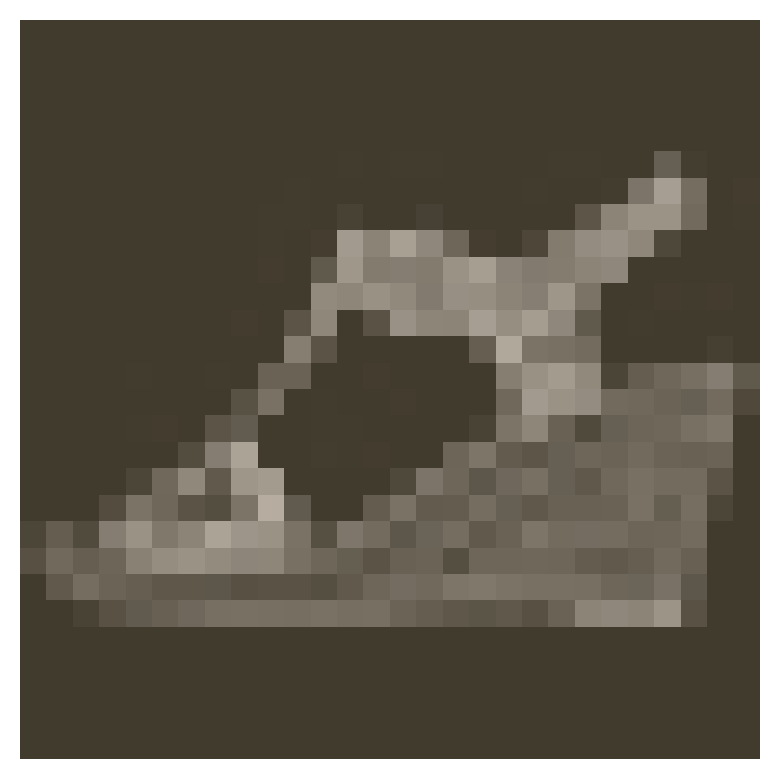

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

![png](output_4_0.png)


## 构建网络

在这里，我将使用与第五部分中一样的模型。

In [4]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [5]:
model = Network(784,10, [500, 100])
model

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# 训练网络

并使用之前一样的方法来训练网络。

In [6]:
# Create the network, define the criterion and optimizer
model = Network(784, 10, [500, 100])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
epochs = 2
steps = 0
running_loss = 0
print_every = 100

for e in range(epochs):
    for images, labels in trainloader:
        steps += 1
        # 将图像扁平化为784长度的向量
        images = images.view(images.size()[0], 784)
        
        # 将图像和标签包装在变量中，以便计算梯度
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = model.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # 模型评估模式，禁用dropout
            model.eval()
            
            accuracy = 0
            test_loss = 0
            with torch.no_grad():  # 禁用梯度计算
                for ii, (images, labels) in enumerate(testloader):
                    images = images.view(images.size()[0], 784)
                    inputs = Variable(images)
                    labels = Variable(labels)

                    output = model.forward(inputs)
                    test_loss += criterion(output, labels).item()
                    
                    # 计算准确率
                    ps = torch.exp(output).data
                    equality = (labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # 确保训练时启用dropout
            model.train()

Epoch: 1/2..  Training Loss: 1.087..  Test Loss: 0.652..  Test Accuracy: 0.757
Epoch: 1/2..  Training Loss: 0.733..  Test Loss: 0.580..  Test Accuracy: 0.790
Epoch: 1/2..  Training Loss: 0.658..  Test Loss: 0.527..  Test Accuracy: 0.806
Epoch: 1/2..  Training Loss: 0.606..  Test Loss: 0.509..  Test Accuracy: 0.817
Epoch: 1/2..  Training Loss: 0.590..  Test Loss: 0.503..  Test Accuracy: 0.811
Epoch: 1/2..  Training Loss: 0.598..  Test Loss: 0.510..  Test Accuracy: 0.809
Epoch: 1/2..  Training Loss: 0.563..  Test Loss: 0.477..  Test Accuracy: 0.820
Epoch: 1/2..  Training Loss: 0.544..  Test Loss: 0.468..  Test Accuracy: 0.824
Epoch: 1/2..  Training Loss: 0.547..  Test Loss: 0.468..  Test Accuracy: 0.827
Epoch: 2/2..  Training Loss: 0.512..  Test Loss: 0.457..  Test Accuracy: 0.834
Epoch: 2/2..  Training Loss: 0.527..  Test Loss: 0.469..  Test Accuracy: 0.825
Epoch: 2/2..  Training Loss: 0.508..  Test Loss: 0.464..  Test Accuracy: 0.830
Epoch: 2/2..  Training Loss: 0.527..  Test Loss: 0.4

## 保存和加载模型

可以想象，在每次使用神经网络时都重新进行训练很不现实。因此，我们可以保存之前训练好的网络，并在继续训练或是进行预测时加载网络。

PyTorch 网络的参数都存储在模型的 `state_dict` 中。我们可以看到这个状态字典包含了每个层的权重和偏差矩阵。

In [8]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])


Our network: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=500)
    (1): Linear(in_features=500, out_features=100)
  )
  (output): Linear(in_features=100, out_features=10)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])

最简单的做法是使用 `torch.save` 来保存状态字典。比如，我们可以将它保存到文件 `'checkpoint.pth'` 中。

In [9]:
torch.save(model.state_dict(), 'checkpoint.pth')

接着，我们可以使用 `torch.load` 来加载这个状态字典。

In [10]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])


odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])


要将状态字典加载到神经网络中，你需要使用 `model.load_state_dict(state_dict)'`。

In [11]:
model.load_state_dict(state_dict)

<All keys matched successfully>

这看上去十分简单，但实际情况更加复杂。只有当模型结构与检查点的结构完全一致时，状态字典才能成功加载。如果我在创建模型时使用了不同的结构，便无法顺利加载。

In [12]:
# # Try this
# net = Network(784, 10, [400, 200, 100])
# # This will throw an error because the tensor sizes are wrong!
# net.load_state_dict(state_dict)

---------------------------------------------------------------------------

RuntimeError                              Traceback (most recent call last)

~/miniconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/module.py in load_state_dict(self, state_dict, strict)
    481                 try:
--> 482                     own_state[name].copy_(param)
    483                 except Exception:


RuntimeError: inconsistent tensor size, expected tensor [400 x 784] and src [500 x 784] to have the same number of elements, but got 313600 and 392000 elements respectively at /Users/soumith/minicondabuild3/conda-bld/pytorch_1512381214802/work/torch/lib/TH/generic/THTensorCopy.c:86

During handling of the above exception, another exception occurred:


RuntimeError                              Traceback (most recent call last)

<ipython-input-18-74e14cc8e983> in <module>()
      2 net = Network(784, 10, [400, 200, 100])
      3 # This will throw an error because the tensor sizes are wrong!
----> 4 net.load_state_dict(state_dict)


~/miniconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/module.py in load_state_dict(self, state_dict, strict)
    485                                        'whose dimensions in the model are {} and '
    486                                        'whose dimensions in the checkpoint are {}.'
--> 487                                        .format(name, own_state[name].size(), param.size()))
    488             elif strict:
    489                 raise KeyError('unexpected key "{}" in state_dict'


RuntimeError: While copying the parameter named hidden_layers.0.weight, whose dimensions in the model are torch.Size([400, 784]) and whose dimensions in the checkpoint are torch.Size([500, 784]).


这意味着我们需要重建一个与训练时完全相同的模型。有关模型结构的信息需要与状态字典一起存储在检查点中。为了做到这一点，你需要构建一个字典，字典中包含重建模型的全部信息。

In [13]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

现在，检查点中包含了重建训练模型所需的全部信息。你可以随意将它编写为函数。相似地，我们也可以编写一个函数来加载检查点。

In [14]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [15]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=500)
    (1): Linear(in_features=500, out_features=100)
  )
  (output): Linear(in_features=100, out_features=10)
)